In [2]:
from fim import apriori, eclat, fpgrowth, fim
import numpy as np
import pandas as pd

# Data preparation

In [3]:
mnist_array = np.loadtxt("mnist_8x8_image.csv", delimiter=',')
mnist_array = mnist_array.astype(np.int64)
col_names = [str(i) for i in (range(mnist_array.shape[1]))]
mnist_df = pd.DataFrame(mnist_array, columns=col_names)
mnist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
3,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,0,1,1,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
mnist_label = np.loadtxt("mnist_8x8_label_onehot.csv", delimiter=",")
col_names = [str(64 + i) for i in range(mnist_label.shape[1])]
mnist_label = pd.DataFrame(mnist_label, columns=col_names)

mnist_label.head(10)

,64,65,66,67,68,69,70,71,72,73
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
mnist_label_int = np.argmax(mnist_label.values, axis=1)
mnist_label_int = pd.DataFrame(mnist_label_int, columns=['label'])
mnist_label_int.head()
mnist_label_int.label.value_counts()

3    92
5    91
2    91
1    91
7    90
6    90
0    90
4    89
9    88
8    86
Name: label, dtype: int64

### concat (image + label) dataframe

In [6]:
mnist_conc = pd.concat([mnist_df, mnist_label], axis=1)
mnist_conc.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0,0,0,1,1,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,1,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,1,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Data conversion

table -> transaction 

In [7]:
def pickupColumns(df, ind):
    colnames = df.columns
    return  list(np.array(colnames[df.iloc[ind,:] ==1],dtype=np.int64))

In [8]:
transactions = [pickupColumns(mnist_df,i) for i in range(mnist_df.shape[0])]
transactions = np.array(transactions)

transactions_conc = [pickupColumns(mnist_conc,i) for i in range(mnist_conc.shape[0])]
transactions_conc = np.array(transactions_conc)
transactions_conc


array([list([3, 4, 10, 11, 12, 13, 18, 21, 22, 26, 29, 30, 34, 37, 38, 42, 45, 50, 52, 53, 59, 60, 64]),
       list([3, 4, 11, 12, 13, 19, 20, 26, 27, 28, 35, 36, 43, 44, 51, 52, 59, 60, 61, 65]),
       list([4, 5, 11, 12, 13, 18, 19, 20, 21, 28, 29, 34, 35, 36, 41, 42, 43, 50, 51, 52, 53, 60, 61, 62, 66]),
       list([3, 4, 9, 10, 12, 19, 20, 27, 28, 36, 37, 45, 46, 50, 53, 54, 59, 60, 61, 67]),
       list([4, 12, 19, 27, 29, 30, 34, 35, 37, 42, 43, 44, 45, 52, 53, 60, 68]),
       list([2, 3, 10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 37, 45, 46, 52, 53, 58, 59, 60, 61, 69]),
       list([3, 4, 11, 12, 18, 19, 26, 27, 34, 35, 42, 43, 44, 45, 51, 52, 53, 54, 59, 60, 61, 70]),
       list([3, 4, 5, 6, 13, 14, 20, 21, 26, 27, 28, 29, 34, 35, 36, 43, 50, 51, 58, 71]),
       list([2, 3, 4, 10, 11, 12, 13, 18, 19, 21, 27, 28, 29, 35, 36, 42, 43, 44, 45, 50, 53, 54, 58, 59, 60, 61, 72]),
       list([2, 3, 10, 11, 12, 13, 18, 19, 20, 21, 26, 28, 29, 34, 35, 36, 37, 45, 46, 52, 53, 58,

# frequent items in mnist_array

In [39]:
%time res = np.array(fpgrowth(transactions, supp=10, zmin=7, report='s'))

freq_df = pd.DataFrame(res, columns=['itemsets', 'support'])
freq_df = freq_df.sort_values('support', ascending=False)
freq_df.index = np.arange(freq_df.shape[0])
freq_df

CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 194 ms


,itemsets,support
0,"(10, 51, 12, 3, 4, 59, 11)",0.331849
1,"(10, 12, 60, 3, 4, 11, 59)",0.317372
2,"(53, 10, 12, 60, 3, 11, 59)",0.31069
3,"(53, 18, 10, 60, 3, 59, 11)",0.308463
4,"(52, 51, 12, 3, 4, 59, 11)",0.308463
5,"(18, 10, 60, 3, 4, 59, 11)",0.30735
6,"(51, 12, 60, 3, 4, 59, 11)",0.306236
7,"(53, 10, 60, 3, 4, 59, 11)",0.305122
8,"(18, 10, 12, 3, 4, 59, 11)",0.304009
9,"(13, 10, 12, 3, 4, 59, 11)",0.302895


## association rules in mnist_conc

In [104]:
%time res = np.array(fpgrowth(transactions_conc, conf=40, supp=3, zmin=5, report='C', target='r', eval='x', agg='m', thresh=10))

freq_df = pd.DataFrame(res, columns=['consequent','antecedent', 'confident'])
freq_df = freq_df.sort_values('confident', ascending=False)
freq_df.index = np.arange(freq_df.shape[0])
print(freq_df.shape)
#freq_df

CPU times: user 9min 31s, sys: 32.7 s, total: 10min 4s
Wall time: 42min 38s


MemoryError: Unable to allocate array with shape (678523617,) and data type object

In [100]:
rules = freq_df[freq_df.consequent >=64]
max_rules = rules.groupby(rules['consequent']).count()
max_rules

,antecedent,confident
consequent,,
64,84094,84094
65,3125,3125
66,134,134
67,322,322
68,38,38
69,73,73
70,2526,2526
71,208,208
72,1305,1305


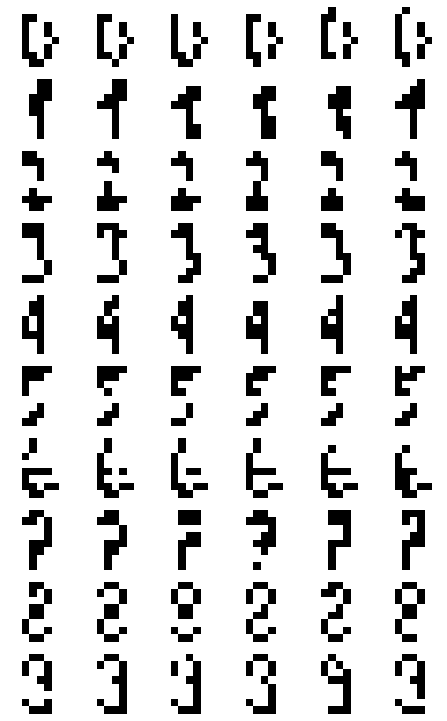

In [103]:
import  matplotlib.pyplot as plt 
row = 10
col = 6

_, axes = plt.subplots(row,col, figsize = (col*1.3,row*1.3))


for i in range(row):
    r = rules[rules.consequent==(i+64)]
    r_best5 = r[:col]
    for j in range(col):
        ax = axes[i][j]
        image = np.zeros(64)
        image[list(r_best5.iloc[j,:].antecedent)] =1
        ax.set_axis_off()
        ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')

    

In [92]:
%debug

> <ipython-input-91-2d2698ffb5c6>(15)<module>()
     13         ax = axes[i][j]
     14         image = np.zeros(64)
---> 15         image = image[list(r_best5.iloc[j,:].antecedent)] =1
     16         ax.set_axis_off()
     17         ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')

ipdb> r_best5.iloc[j,:]
consequent                                              64
antecedent    (42, 34, 50, 21, 37, 45, 53, 18, 52, 10, 59)
confident                                              100
Name: 14885, dtype: object
ipdb> r_best5.iloc[j,:].antecedent
(42, 34, 50, 21, 37, 45, 53, 18, 52, 10, 59)
ipdb> image[list(r_best5.iloc[j,:].antecedent)]
*** TypeError: 'int' object is not subscriptable
ipdb> image
1
ipdb> image
1
ipdb> r_best5
      consequent                                       antecedent confident
14885         64     (42, 34, 50, 21, 37, 45, 53, 18, 52, 10, 59)       100
14909         64      (42, 34, 50, 21, 37, 45, 53, 18, 52, 10, 3)       100
14922        

In [47]:
for i in range(10):
    print(i)
    print(rules[rules.consequent==(i+64)])
    print()

0
        consequent                              antecedent  support
1124285         64        (42, 34, 21, 53, 18, 60, 59, 11)  82.4176
1143085         64         (42, 34, 21, 53, 18, 60, 3, 11)  82.2222
1143087         64     (42, 34, 21, 53, 18, 60, 3, 59, 11)  82.2222
1190228         64            (42, 34, 21, 53, 18, 60, 11)  81.5217
1206767         64            (42, 34, 21, 53, 26, 60, 59)  81.3187
1206919         64            (42, 34, 21, 53, 26, 18, 60)  81.3187
1206933         64        (42, 34, 21, 53, 26, 18, 60, 59)  81.3187
1224815         64        (42, 34, 50, 21, 53, 18, 60, 59)  81.1111
1225448         64         (42, 34, 21, 53, 26, 18, 60, 3)  81.1111
1225467         64     (42, 34, 21, 53, 26, 18, 60, 3, 59)  81.1111
1225530         64             (42, 34, 21, 53, 26, 60, 3)  81.1111
1225614         64         (42, 34, 21, 53, 26, 60, 3, 59)  81.1111
1229323         64            (42, 34, 21, 53, 18, 60, 59)  81.0526
1243209         64             (42, 34, 21, 53

        consequent                               antecedent  support
2541601         73                 (29, 21, 37, 18, 28, 60)  64.5161
3000309         73                 (21, 37, 45, 18, 28, 60)  58.8889
3015666         73                 (29, 21, 27, 18, 28, 60)  58.6957
3103651         73                 (29, 21, 27, 18, 28, 11)  57.6087
3141000         73             (29, 21, 37, 53, 28, 60, 11)  57.1429
3172969         73                 (29, 37, 53, 18, 28, 60)   56.701
3180326         73                 (29, 37, 18, 28, 12, 60)  56.6667
3180635         73                 (29, 21, 18, 28, 10, 60)  56.6667
3214383         73                 (29, 21, 53, 18, 28, 60)    56.25
3220697         73              (29, 21, 37, 28, 60, 3, 59)  56.1224
3239840         73             (29, 21, 27, 37, 53, 28, 60)   55.914
3248951         73                 (29, 21, 37, 53, 28, 11)  55.7895
3249018         73                 (29, 21, 45, 18, 28, 60)  55.7895
3257828         73                

In [ ]:
transactions = [pickupColumns(mnist_df,i) for i in range(mnist_df.shape[0])]
transactions = np.array(transactions)

%time res = np.array(fpgrowth(transactions, supp=5, zmin=10, report='s'))

freq_df = pd.DataFrame(res, columns=['itemsets', 'support'])
freq_df = freq_df.sort_values('support', ascending=False)
freq_df.index = np.arange(freq_df.shape[0])
freq_df.head()

In [17]:
transactions = [pickupColumns(mnist_df,i) for i in range(mnist_df.shape[0])]
transactions = np.array(transactions)

%time res = fpgrowth(transactions, supp=5, zmin=10, report='s', target='r')
res
freq_df = pd.DataFrame(res, columns=['consequent','antecedent', 'support'])
freq_df = freq_df.sort_values('support', ascending=False)
freq_df.index = np.arange(freq_df.shape[0])
freq_df.head()

CPU times: user 8.85 s, sys: 268 ms, total: 9.11 s
Wall time: 9.09 s


,consequent,antecedent,support
0,45,"(53, 18, 10, 12, 60, 3, 4, 59, 11)",0.169265
1,60,"(45, 53, 18, 10, 12, 3, 4, 59, 11)",0.169265
2,11,"(45, 53, 18, 10, 12, 60, 3, 4, 59)",0.169265
3,59,"(45, 53, 18, 10, 12, 60, 3, 4, 11)",0.169265
4,3,"(45, 53, 18, 10, 12, 60, 4, 59, 11)",0.169265


In [16]:
np.array(res)

array([[11, (28, 10, 36, 51, 12, 60, 3, 4, 59), 0.12026726057906459],
       [59, (28, 10, 36, 51, 12, 60, 3, 4, 11), 0.12026726057906459],
       [4, (28, 10, 36, 51, 12, 60, 3, 59, 11), 0.12026726057906459],
       ...,
       [4, (33, 42, 43, 44, 34, 26, 18, 36, 11), 0.0400890868596882],
       [52, (33, 42, 43, 44, 34, 26, 18, 36, 11), 0.044543429844097995],
       [37, (33, 42, 43, 44, 34, 26, 18, 36, 11), 0.044543429844097995]],
      dtype=object)

In [10]:
transactions = [pickupColumns(mnist_df,i) for i in range(mnist_df.shape[0])]
transactions = np.array(transactions)

%time res = np.array(fim(transactions, supp=5, zmin=10, report='s'))

freq_df = pd.DataFrame(res, columns=['itemsets', 'support'])
freq_df = freq_df.sort_values('support', ascending=False)
freq_df.index = np.arange(freq_df.shape[0])
freq_df.head()

CPU times: user 559 ms, sys: 16.1 ms, total: 575 ms
Wall time: 574 ms


,itemsets,support
0,"(45, 53, 18, 10, 12, 60, 3, 4, 11, 59)",0.169265
1,"(42, 34, 50, 53, 26, 18, 60, 3, 59, 11)",0.164811
2,"(42, 34, 50, 26, 18, 51, 60, 3, 59, 11)",0.164811
3,"(18, 52, 10, 51, 12, 60, 3, 4, 11, 59)",0.164811
4,"(13, 45, 53, 10, 12, 60, 3, 4, 11, 59)",0.163697


In [59]:
freq_df

,itemsets,support
0,"(45, 53, 18, 10, 12, 60, 3, 4, 11, 59)",0.169265
1,"(42, 34, 50, 53, 26, 18, 60, 3, 59, 11)",0.164811
2,"(42, 34, 50, 26, 18, 51, 60, 3, 59, 11)",0.164811
3,"(18, 52, 10, 51, 12, 60, 3, 4, 11, 59)",0.164811
4,"(13, 45, 53, 10, 12, 60, 3, 4, 11, 59)",0.163697
5,"(45, 53, 26, 18, 10, 60, 3, 4, 59, 11)",0.16147
6,"(53, 18, 10, 51, 12, 60, 3, 4, 11, 59)",0.16147
7,"(50, 18, 10, 51, 12, 60, 3, 4, 11, 59)",0.16147
8,"(50, 45, 53, 18, 10, 60, 3, 4, 11, 59)",0.16147
9,"(53, 52, 10, 51, 12, 60, 3, 4, 11, 59)",0.158129
